#**Import Library**

In [ ]:
pip install deep_translator

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from deep_translator import GoogleTranslator
import time
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from deep_translator.exceptions import NotValidPayload, TranslationNotFound,RequestError
import os
import torch
from transformers import AutoTokenizer, AutoModel
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import RobertaTokenizerFast, RobertaModel
from transformers import AutoTokenizer, AutoModel
from huggingface_hub import login
from sklearn.metrics import confusion_matrix
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import BertTokenizer, TFBertModel
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

#**Function**

In [ ]:
def translate_text_helsinki(text):
    attempt = 0
    while attempt < RETRY_LIMIT:
        try:
            tokenized_text = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
            if tokenized_text.input_ids.size(1) > MAX_TOKEN:
                print(f"Text exceeds maximum length of {MAX_TOKEN} token and will be truncated.")
                text = text[:MAX_LENGTH - 10]


            print("##############")
            print(text)
            outputs = model.generate(input_ids=tokenized_text.input_ids, attention_mask=tokenized_text.attention_mask, num_beams=5, num_return_sequences=1)
            translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            return translated_text
        except (NotValidPayload, TranslationNotFound) as e:
            print(f"An error occurred during translation: {e}")
            return 'Error'
        except RequestError as e:
            attempt += 1
            wait_time = 2 ** attempt
            print(f"Request error: {e}. Retrying {attempt}/{RETRY_LIMIT} after {wait_time} seconds...")
            time.sleep(wait_time)
    print(f"Request failed after {RETRY_LIMIT} attempts. Skipping this text.")
    return 'Request failed'

In [ ]:
def translate_text(text):
    attempt = 0
    while attempt < RETRY_LIMIT:
        try:
            if len(text) > MAX_LENGTH:
                print(f"Text exceeds maximum length of {MAX_LENGTH} characters and will be truncated.")
                text = text[:MAX_LENGTH - 100]
            translated_text = translator.translate(text)
            return translated_text
        except (NotValidPayload, TranslationNotFound) as e:
            print(f"An error occurred during translation: {e}")
            return 'Too long'
        except RequestError as e:
            attempt += 1
            wait_time = 2 ** attempt
            print(f"Request error: {e}. Retrying {attempt}/{RETRY_LIMIT} after {wait_time} seconds...")
            time.sleep(wait_time)
    print(f"Request failed after {RETRY_LIMIT} attempts. Skipping this text.")
    return 'Request failed'

In [ ]:
class YourDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        item = {'text': self.texts[idx]}
        if self.labels is not None:
            item['label'] = self.labels[idx]
        return item

In [ ]:
def tokenize_batch(texts, has_labels=True):
    return tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

In [ ]:
def sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fn = cm[1, 0]
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def balanced_accuracy(y_true, y_pred):
    sens = sensitivity(y_true, y_pred)
    spec = specificity(y_true, y_pred)
    return (sens + spec) / 2


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def sensitivity_severity(cm, class_index):
    tp = cm[class_index, class_index]
    fn = np.sum(cm[class_index, :]) - tp
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def specificity_severity(cm, class_index):
    tn = np.sum(cm) - np.sum(cm[class_index, :]) - np.sum(cm[:, class_index]) + cm[class_index, class_index]
    fp = np.sum(cm[:, class_index]) - cm[class_index, class_index]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def balanced_accuracy_severity(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)

    if y_true.ndim != 1 or y_pred.ndim != 1:
        raise ValueError("y_true e y_pred devono essere array monodimensionali.")

    num_classes = 4
    if not np.all((0 <= y_true) & (y_true < num_classes)):
        raise ValueError("y_true contiene valori fuori dal range atteso.")
    if not np.all((0 <= y_pred) & (y_pred < num_classes)):
        raise ValueError("y_pred contiene valori fuori dal range atteso.")

    cm = confusion_matrix(y_true, y_pred)
    sens_list = []
    spec_list = []
    for i in range(num_classes):
        sens_list.append(sensitivity_severity(cm, i))
        spec_list.append(specificity_severity(cm, i))

    sens = np.mean(sens_list)
    spec = np.mean(spec_list)
    return (sens + spec) / 2


In [ ]:
def training(dataset):
    column = dataset.columns[0]
    label_encoder = LabelEncoder()
    dataset['label'] = label_encoder.fit_transform(dataset['label'])
    train_texts, val_texts, train_labels, val_labels = train_test_split(dataset[column], dataset['label'], test_size=0.2, random_state=42)
    train_dataset = YourDataset(train_texts.tolist(), train_labels.tolist())
    val_dataset = YourDataset(val_texts.tolist(), val_labels.tolist())

    num_epochs = 8
    batch_size = 1
    optimizer = AdamW(model.parameters(), lr=3e-5)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_balanced_accuracy = 0.0

    for epoch in range(num_epochs):
        print('############################')
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        for i, batch in enumerate(DataLoader(train_dataset, batch_size=batch_size, shuffle=True)):
            print('************************************')
            print(f"Batch {i+1}")


            texts = batch['text']
            inputs = tokenize_batch(texts)

            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

        model.eval()
        total_correct = 0
        total_samples = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for batch in DataLoader(val_dataset, batch_size=batch_size):
                texts = batch['text']
                inputs = tokenize_batch(texts)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = batch['label'].to(device)

                outputs = model(**inputs)
                predictions = torch.argmax(outputs.logits, dim=1)
                total_correct += (predictions == labels).sum().item()
                total_samples += len(labels)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                print('++++++++++++++++++++++++++++++++++++++++++++++')
                print(predictions)

        accuracy = total_correct / total_samples
        b_accuracy = balanced_accuracy(all_labels, all_predictions)
        print(f"Epoch {epoch+1}, Validation Accuracy: {accuracy:.4f}, Balanced Accuracy: {b_accuracy:.4f}")

        if b_accuracy > best_balanced_accuracy:
            best_balanced_accuracy = b_accuracy
            torch.save(model.state_dict(), 'best_model_weights.pth')
            print(f"New best model saved with balanced accuracy: {best_balanced_accuracy:.4f}")
    model.load_state_dict(torch.load('best_model_weights.pth'))


In [ ]:
def translate_label(dataset):
  dataset['label'][dataset['label'] == 'minimum'] = 0
  dataset['label'][dataset['label'] == 'moderate'] = 2
  dataset['label'][dataset['label'] == 'mild'] = 1
  dataset['label'][dataset['label'] == 'severe'] = 3
  dataset['predictions'][dataset['predictions'] == 'minimum'] = 0
  dataset['predictions'][dataset['predictions'] == 'moderate'] = 2
  dataset['predictions'][dataset['predictions'] == 'mild'] = 1
  dataset['predictions'][dataset['predictions'] == 'severe'] = 3



In [ ]:
def testing(dataset, dataset_training):
    column = dataset.columns[0]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_texts = dataset[column].tolist()
    test_dataset = YourDataset(test_texts)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    predictions = []
    with torch.no_grad():
        for batch in test_dataloader:


            texts = batch['text']
            if isinstance(texts, list):
                if all(isinstance(text, str) for text in texts):
                    inputs = tokenize_batch(texts, has_labels=False)
                    inputs = {k: v.to(device) for k, v in inputs.items()}

                    outputs = model(**inputs)
                    batch_predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                    predictions.extend(batch_predictions)
                else:
                    print("batch['text'] contiene elementi non di tipo stringa.")
                    if all(isinstance(text, list) for text in texts):
                        texts = [" ".join(sublist) for sublist in texts]
                        inputs = tokenize_batch(texts, has_labels=False)
                        inputs = {k: v.to(device) for k, v in inputs.items()}

                        outputs = model(**inputs)
                        batch_predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                        predictions.extend(batch_predictions)
                    else:
                        raise ValueError("batch['text'] contiene elementi di tipo sconosciuto.")
            else:
                raise ValueError("batch['text'] non è una lista.")

    dataset['predictions'] = predictions
    print(dataset)

    if 'label' in dataset.columns:
        all_labels = dataset['label'].tolist()
        all_predictions = dataset['predictions'].tolist()
        bal_acc = balanced_accuracy(all_labels, all_predictions)
        print(f"Balanced Accuracy: {bal_acc:.4f}")
    else:
        print("No labels provided, cannot calculate balanced accuracy.")
        bal_acc = None

    return bal_acc


In [ ]:
def tokenize_batch_qwen(batch, has_labels=True):
    texts = batch['text']
    inputs = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    if has_labels:
        labels = torch.tensor(batch['label'])
        return inputs, labels
    return inputs

def sensitivity_qwen(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape[0] == 1:
        return 1.0 if y_true[0] == 1 else 0.0
    tp = cm[1, 1]
    fn = cm[1, 0]
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def specificity_qwen(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape[0] == 1:
        return 1.0 if y_true[0] == 0 else 0.0
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def balanced_accuracy_qwen(y_true, y_pred):
    sens = sensitivity_qwen(y_true, y_pred)
    spec = specificity_qwen(y_true, y_pred)
    return (sens + spec) / 2

In [ ]:
def training_qwen(dataset):
    column = dataset.columns[0]
    label_encoder = LabelEncoder()
    dataset['label'] = label_encoder.fit_transform(dataset['label'])
    train_texts, val_texts, train_labels, val_labels = train_test_split(dataset[column], dataset['label'], test_size=0.2, random_state=42)
    train_dataset = YourDataset(train_texts.tolist(), train_labels.tolist())
    val_dataset = YourDataset(val_texts.tolist(), val_labels.tolist())

    num_epochs = 8
    batch_size = 1
    optimizer = AdamW(model.parameters(), lr=3e-5)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_balanced_accuracy = 0.0

    for epoch in range(num_epochs):
        print('############################')
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        for i, batch in enumerate(DataLoader(train_dataset, batch_size=batch_size, shuffle=True)):
            print('************************************')
            print(f"Batch {i+1}")
            print(batch)
            inputs, labels = tokenize_batch_qwen(batch)

            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

        model.eval()
        total_correct = 0
        total_samples = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for batch in DataLoader(val_dataset, batch_size=batch_size):
                inputs, labels = tokenize_batch_qwen(batch)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)

                outputs = model(**inputs)
                predictions = torch.argmax(outputs.logits, dim=1)
                total_correct += (predictions == labels).sum().item()
                total_samples += len(labels)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                print('++++++++++++++++++++++++++++++++++++++++++++++')
                print(predictions)

        accuracy = total_correct / total_samples
        b_accuracy = balanced_accuracy(all_labels, all_predictions)
        print(f"Epoch {epoch+1}, Validation Accuracy: {accuracy:.4f}, Balanced Accuracy: {b_accuracy:.4f}")

        if b_accuracy > best_balanced_accuracy:
            best_balanced_accuracy = b_accuracy
            torch.save(model.state_dict(), 'best_model_weights.pth')
            print(f"New best model saved with balanced accuracy: {best_balanced_accuracy:.4f}")
    model.load_state_dict(torch.load('best_model_weights.pth'))

In [ ]:
def testing_qwen(dataset, dataset_training):
    column = dataset.columns[0]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_texts = dataset[column].tolist()
    test_dataset = YourDataset(test_texts)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Impostare batch_size a 1

    predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            inputs = tokenize_batch_qwen(batch, has_labels=False)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            batch_predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(batch_predictions)

    dataset['predictions'] = predictions
    print(dataset)

    all_labels = dataset['label']
    all_predictions = dataset['predictions']

    bal_acc = balanced_accuracy(all_labels, all_predictions)
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    return bal_acc

#**Import Data**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_path = '/content/drive/MyDrive/Thesis/Dataset/'
dreaddit_path= drive_path +'Dreaddit/'
dep_severity_path= drive_path +'DepSeverity/'
sdcnl_path= drive_path +'SDCNL/'

In [ ]:
sdcnl_test_tradotto = pd.read_excel(sdcnl_path+'sdcnl_test_tradotto.xlsx')
sdcnl_test_tradotto.drop(columns=['Unnamed: 0'], inplace=True)
sdcnl_test_tradotto.rename(columns={'is_suicide': 'label'}, inplace=True)
sdcnl_train_tradotto = pd.read_excel(sdcnl_path+'sdcnl_train_tradotto.xlsx')
sdcnl_train_tradotto.drop(columns=['Unnamed: 0'], inplace=True)
sdcnl_train_tradotto = sdcnl_train_tradotto.dropna()
sdcnl_train_tradotto.rename(columns={'is_suicide': 'label'}, inplace=True)
dreaddit_train_tradotto = pd.read_excel(dreaddit_path+'dreaddit_train_tradotto.xlsx')
dreaddit_train_tradotto.drop(columns=['Unnamed: 0'], inplace=True)
dreaddit_test_tradotto = pd.read_excel(dreaddit_path+'dreaddit_test_tradotto.xlsx')
dreaddit_test_tradotto.drop(columns=['Unnamed: 0'], inplace=True)
dep_severity_tradotto = pd.read_excel(dep_severity_path+'dep_severity_tradotto.xlsx')
dep_severity_tradotto.drop(columns=['Unnamed: 0'], inplace=True)

#Per elaborazione task 2
# dep_severity_tradotto['label'][dep_severity_tradotto['label'] == 'minimum'] = 0
# dep_severity_tradotto['label'][dep_severity_tradotto['label'] == 'moderate'] = 1
# dep_severity_tradotto['label'][dep_severity_tradotto['label'] == 'mild'] = 1
# dep_severity_tradotto['label'][dep_severity_tradotto['label'] == 'severe'] = 1

#Per elaborazione task multiclass
dep_severity_tradotto['label'][dep_severity_tradotto['label'] == 'minimum'] = 0
dep_severity_tradotto['label'][dep_severity_tradotto['label'] == 'mild'] = 1
dep_severity_tradotto['label'][dep_severity_tradotto['label'] == 'moderate'] = 2
dep_severity_tradotto['label'][dep_severity_tradotto['label'] == 'severe'] = 3

In [ ]:
dep_severity_train_tradotto, dep_severity_test_tradotto = train_test_split(dep_severity_tradotto, test_size=0.2, stratify=dep_severity_tradotto['label'], random_state=42)

In [ ]:
sdcnl_train_original = sdcnl_train_tradotto[['selftext', 'label']]
sdcnl_train_google = sdcnl_train_tradotto[['text tradotto', 'label']]
sdcnl_train_helsinki = sdcnl_train_tradotto[['text_tradotto_helsinki', 'label']]

sdcnl_test_original = sdcnl_test_tradotto[['selftext', 'label']]
sdcnl_test_google = sdcnl_test_tradotto[['text tradotto', 'label']]
sdcnl_test_helsinki = sdcnl_test_tradotto[['text_tradotto_helsinki', 'label']]


dreaddit_train_original = dreaddit_train_tradotto[['text', 'label']]
dreaddit_train_google = dreaddit_train_tradotto[['text tradotto', 'label']]
dreaddit_train_helsinki = dreaddit_train_tradotto[['text_tradotto_helsinki', 'label']]

dreaddit_test_original = dreaddit_test_tradotto[['text', 'label']]
dreaddit_test_google = dreaddit_test_tradotto[['text tradotto', 'label']]
dreaddit_test_helsinki = dreaddit_test_tradotto[['text_tradotto_helsinki', 'label']]


dep_severity_train_original = dep_severity_train_tradotto[['text', 'label']]
dep_severity_train_google = dep_severity_train_tradotto[['text tradotto', 'label']]
dep_severity_train_helsinki = dep_severity_train_tradotto[['text_tradotto_helsinki', 'label']]

dep_severity_test_original = dep_severity_test_tradotto[['text', 'label']]
dep_severity_test_google = dep_severity_test_tradotto[['text tradotto', 'label']]
dep_severity_test_helsinki = dep_severity_test_tradotto[['text_tradotto_helsinki', 'label']]

#**Dreaddit**

Il dataset contiene dei Bias, righe in cui i ricercatori chiedono di partecipare al survey. Per evitare che questi commenti interferiscano con l'allenamento e il test del modello, sarà effettuata una fase di preprocessing in cui saranno filtrati e rimossi tutti i commenti non necessari.

In [ ]:
dreaddit_test = pd.read_csv(dreaddit_path+'dreaddit-test.csv')
dreaddit_train = pd.read_csv(dreaddit_path+'dreaddit-train.csv')
combined_df = pd.concat([dreaddit_test, dreaddit_train])

duplicates = combined_df[combined_df['text'].duplicated()]

search_strings = ["7. This study will include only participants", "#NAME?", "__Who I am__:"]
regex_pattern = '|'.join(search_strings)
matching_rows = combined_df[combined_df['text'].str.contains(regex_pattern)]
duplicates = pd.concat([duplicates, matching_rows], ignore_index=True)
id_duplicates = duplicates['id']

dreaddit_train = dreaddit_train[~dreaddit_train['id'].isin(id_duplicates)]
dreaddit_test = dreaddit_test[~dreaddit_test['id'].isin(id_duplicates)]

print("test:", len(dreaddit_test))
print("train:", len(dreaddit_train))

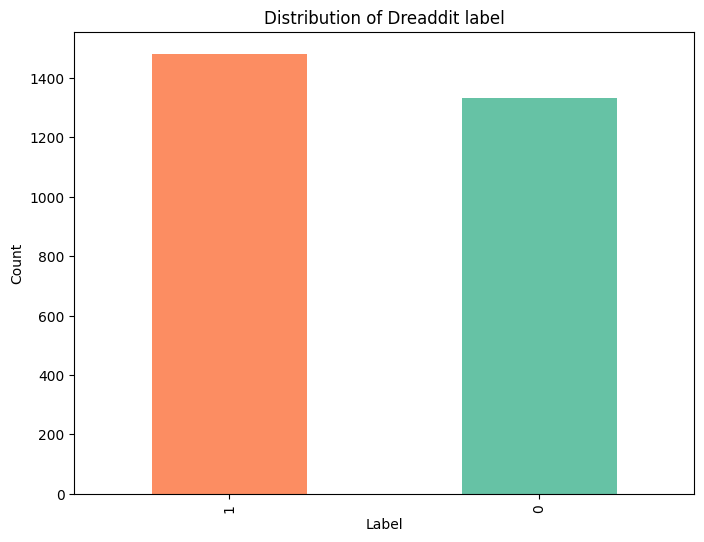

In [ ]:
colors=['#fc8d62','#66c2a5']
label_counts = dreaddit_train['label'].value_counts()
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color = colors)
plt.title('Distribution of Dreaddit label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


<ipython-input-20-c2e9e23160f4>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='label', y='post_length', data=dreaddit_train, ci=None, palette=colors)
<ipython-input-20-c2e9e23160f4>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='post_length', data=dreaddit_train, ci=None, palette=colors)


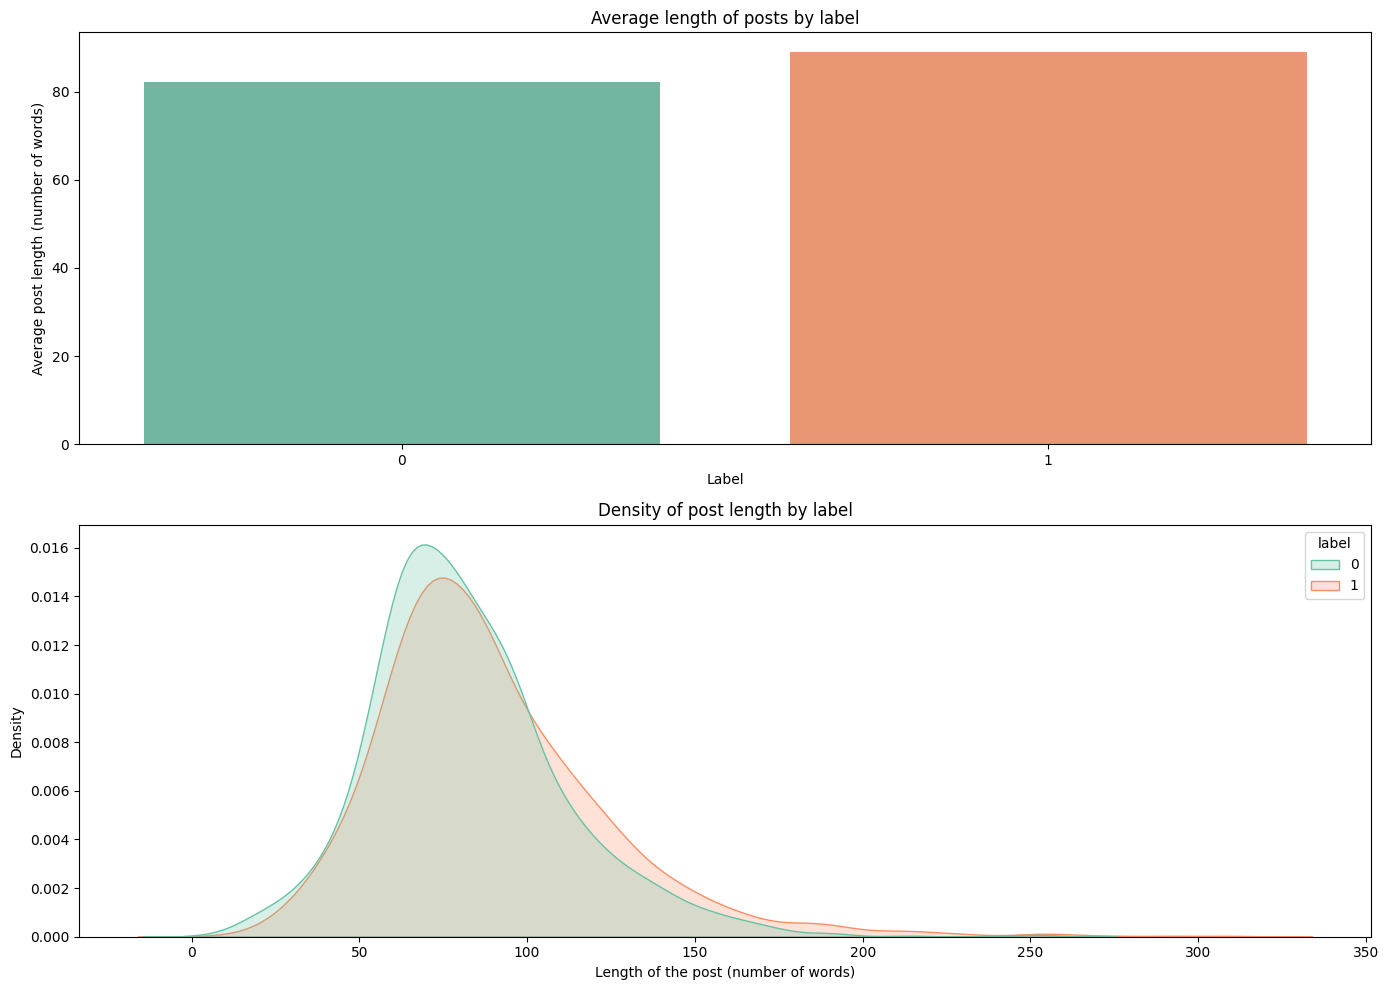

In [ ]:
dreaddit_train['post_length'] = dreaddit_train['text'].apply(lambda x: len(x.split()))
colors=['#66c2a5','#fc8d62']
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='label', y='post_length', data=dreaddit_train, ci=None, palette=colors)
plt.title('Average length of posts by label')
plt.xlabel('Label')
plt.ylabel('Average post length (number of words)')

plt.subplot(2, 1, 2)
sns.kdeplot(data=dreaddit_train, x='post_length', hue='label', fill=True, common_norm=False, palette=colors)
plt.title('Density of post length by label')
plt.xlabel('Length of the post (number of words)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


#**DepSeverity**

In [ ]:
dep_severity = pd.read_csv(dep_severity_path+'Reddit_depression_dataset.csv')
duplicates = dep_severity[dep_severity['text'].duplicated()]
search_strings = ["7. This study will include only participants", "#NAME?", "__Who I am__:"]
regex_pattern = '|'.join(search_strings)
matching_rows = dep_severity[dep_severity['text'].str.contains(regex_pattern)]
duplicates = pd.concat([duplicates, matching_rows])

dep_severity = dep_severity.drop(duplicates.index, errors='ignore')
print("lenght:", len(dep_severity))
dep_severity

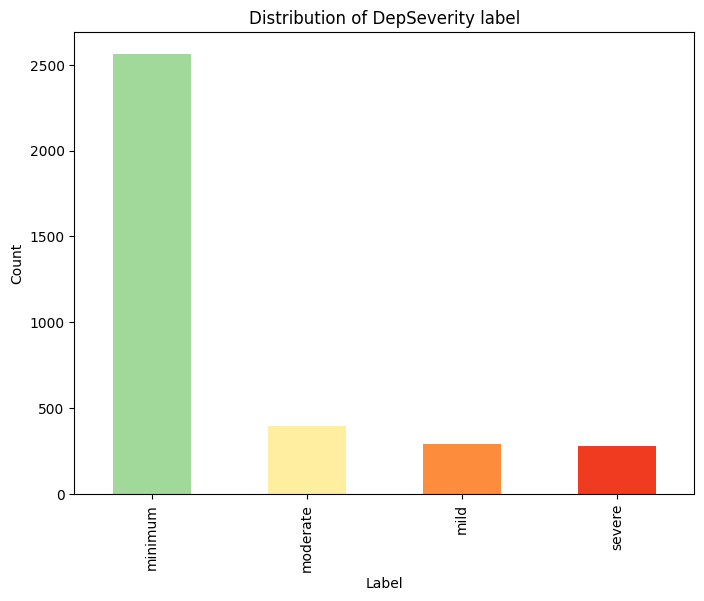

In [ ]:
label_counts = dep_severity['label'].value_counts()

plt.figure(figsize=(8, 6))
colors =['#a1d99b','#ffeda0', '#fd8d3c', '#f03b20']
label_counts.plot(kind='bar', color=colors)
plt.title('Distribution of DepSeverity label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


<ipython-input-23-aa6d298b1e15>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='label', y='post_length', data=dep_severity, ci=None, palette=palette)
<ipython-input-23-aa6d298b1e15>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='post_length', data=dep_severity, ci=None, palette=palette)


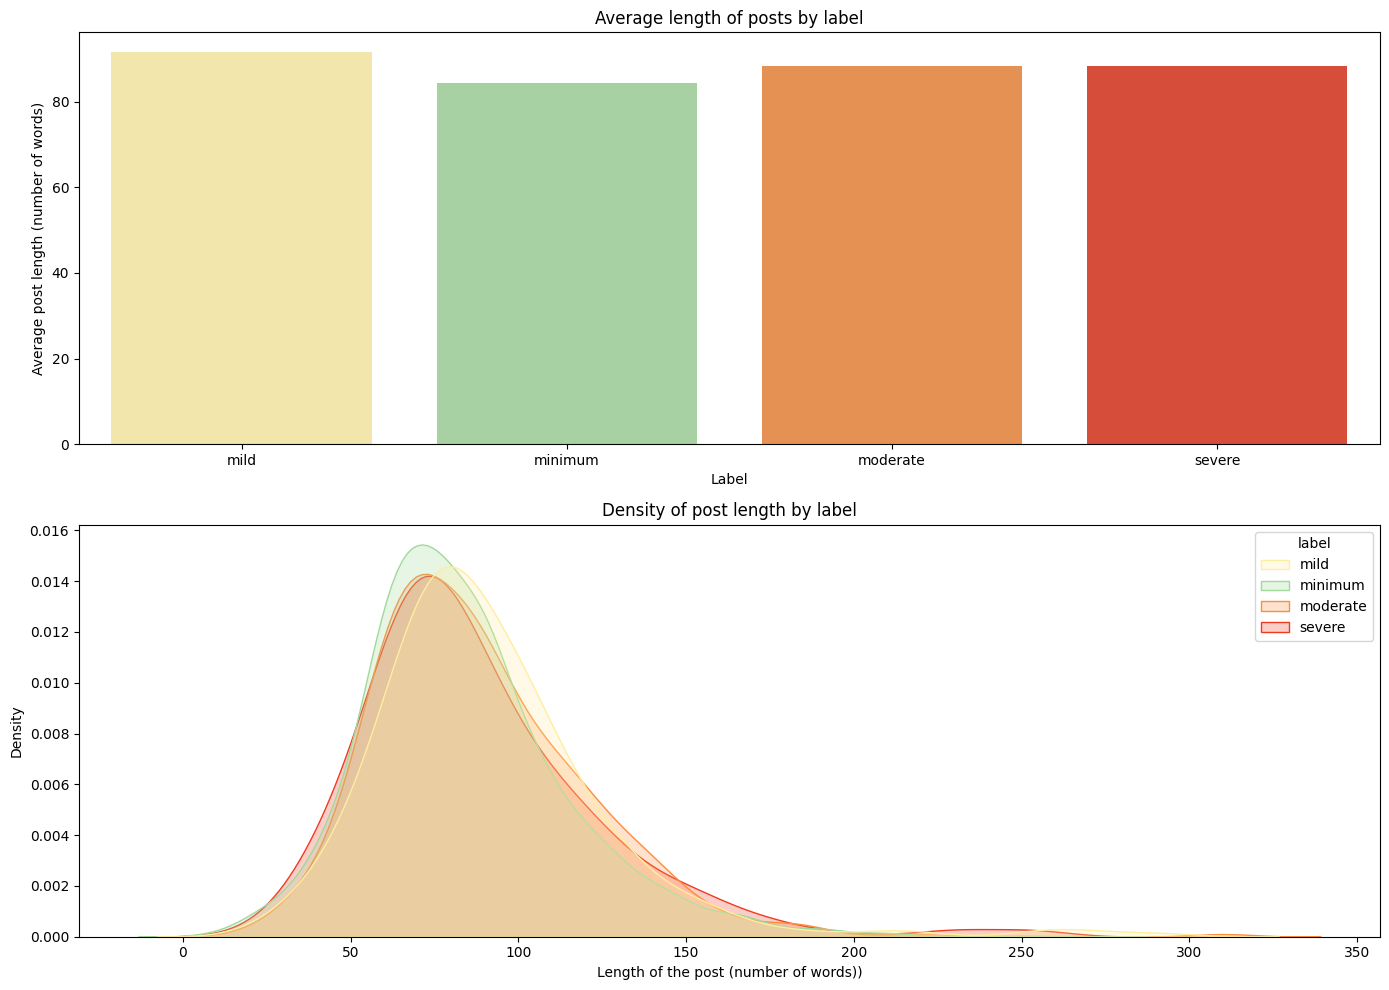

In [ ]:
palette = ['#ffeda0','#a1d99b', '#fd8d3c', '#f03b20']
colors=['#66c2a5','#fc8d62']
plt.figure(figsize=(14, 10))
dep_severity['post_length'] = dep_severity['text'].apply(lambda x: len(x.split()))

plt.subplot(2, 1, 1)
sns.barplot(x='label', y='post_length', data=dep_severity, ci=None, palette=palette)
plt.title('Average length of posts by label')
plt.xlabel('Label')
plt.ylabel('Average post length (number of words)')
plt.subplot(2, 1, 2)
sns.kdeplot(data=dep_severity, x='post_length', hue='label', fill=True, common_norm=False, palette=palette)
plt.title('Density of post length by label')
plt.xlabel('Length of the post (number of words))')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#**SDCNL**

In [ ]:
sdcnl_test = pd.read_csv(sdcnl_path+'testing-set.csv')
sdcnl_test.loc[sdcnl_test['selftext'] == 'emptypost', 'selftext'] = sdcnl_test.loc[sdcnl_test['selftext'] == 'emptypost', 'title']
sdcnl_train = pd.read_csv(sdcnl_path+'training-set.csv')
sdcnl_train.loc[sdcnl_train['selftext'] == 'emptypost', 'selftext'] = sdcnl_train.loc[sdcnl_train['selftext'] == 'emptypost', 'title']
combined_df = pd.concat([sdcnl_test, sdcnl_train])
duplicates = combined_df[combined_df['selftext'].duplicated()]
sdcnl_train = sdcnl_train.drop(duplicates.index, errors='ignore')

print("train:",len(sdcnl_train))
print("test:",len(sdcnl_test))
sdcnl_train

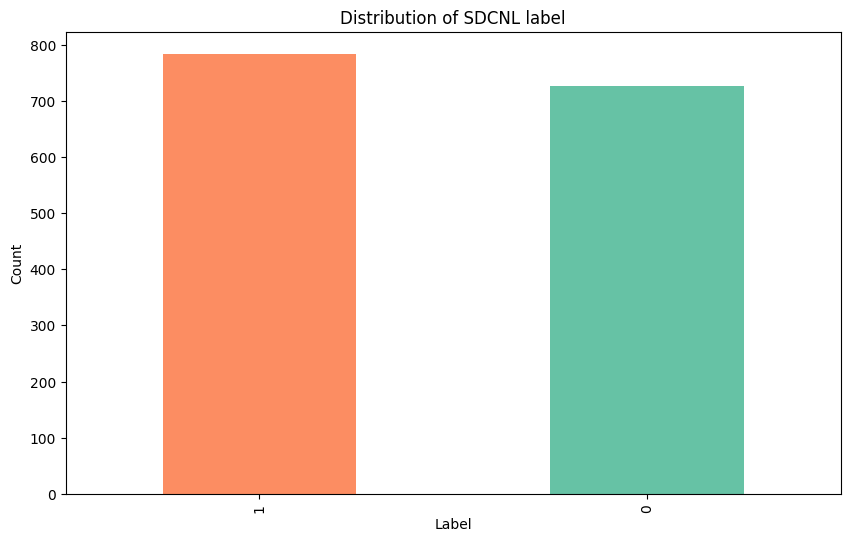

In [ ]:
label_counts = sdcnl_train['is_suicide'].value_counts()
colors=['#fc8d62','#66c2a5']
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=colors)
plt.title('Distribution of SDCNL label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


<ipython-input-26-0cdd7d920ce5>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='is_suicide', y='post_length', data=sdcnl_train, ci=None, palette=colors)
<ipython-input-26-0cdd7d920ce5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_suicide', y='post_length', data=sdcnl_train, ci=None, palette=colors)


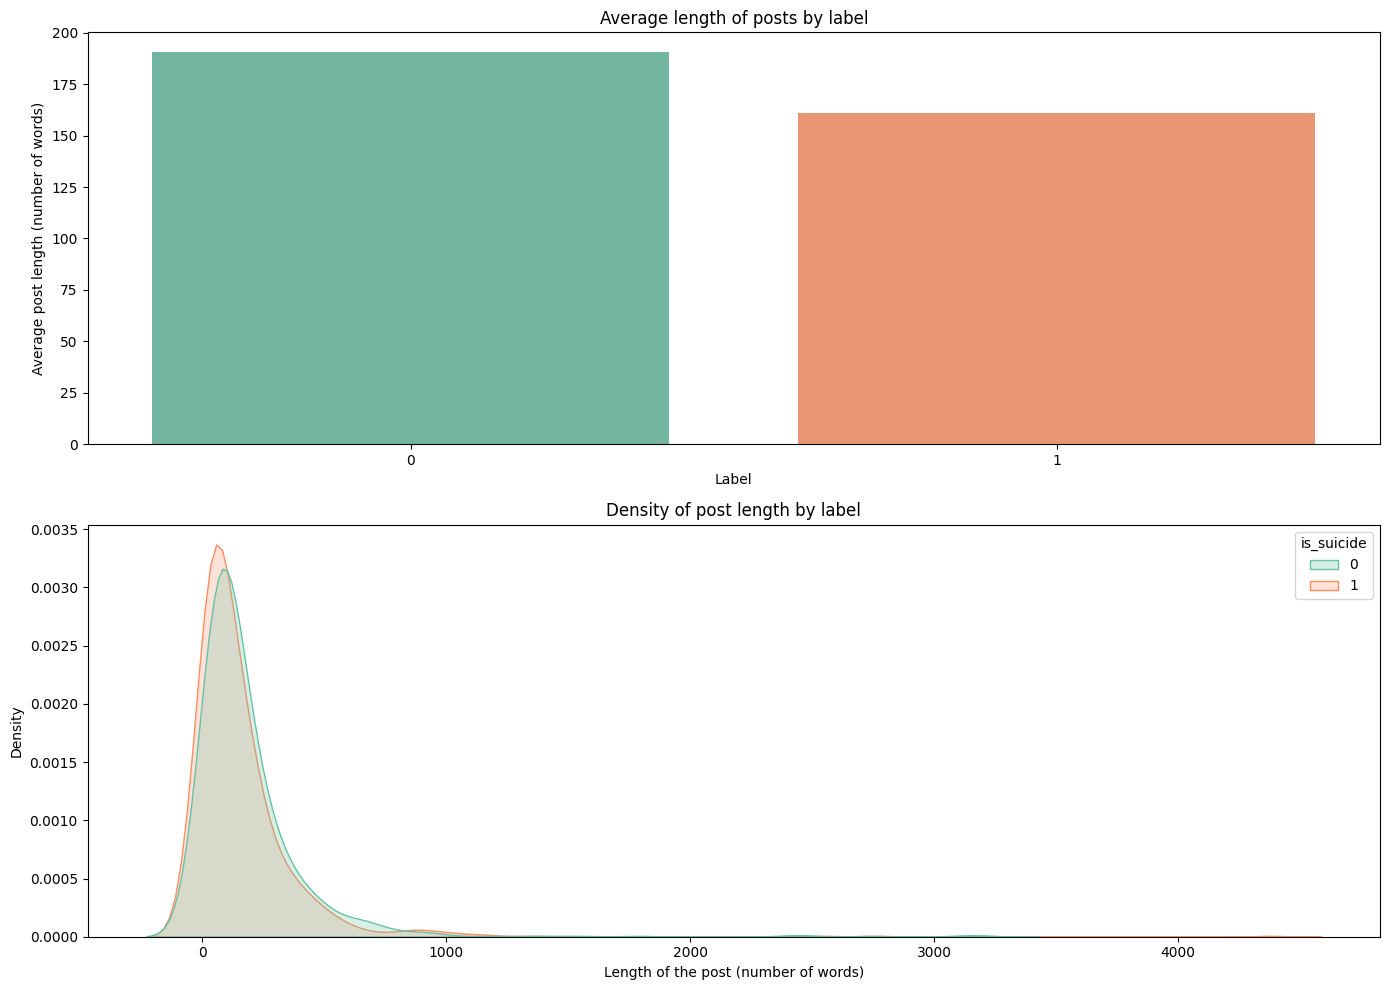

In [ ]:
sdcnl_train['post_length'] = sdcnl_train['selftext'].apply(lambda x: len(x.split()))

plt.figure(figsize=(14, 10))
colors=['#66c2a5','#fc8d62']
plt.subplot(2, 1, 1)
sns.barplot(x='is_suicide', y='post_length', data=sdcnl_train, ci=None, palette=colors)
plt.title('Average length of posts by label')
plt.xlabel('Label')
plt.ylabel('Average post length (number of words)')

plt.subplot(2, 1, 2)
sns.kdeplot(data=sdcnl_train, x='post_length', hue='is_suicide', fill=True, common_norm=False, palette=colors)
plt.title('Density of post length by label')
plt.xlabel('Length of the post (number of words)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


#**Combine DF**

In [ ]:
#Unito sdcnl = 1 perche la label indica se il poster si vuole suicidiare o no. Quini potrebbe essere label = 0, ma poster comunque depresso.
sdcnl_train_original_combined = sdcnl_train_original[sdcnl_train_original['label'] == 1]
sdcnl_test_original_combined = sdcnl_test_original[sdcnl_test_original['label'] == 1]

sdcnl_train_google_combined = sdcnl_train_google[sdcnl_train_google['label'] == 1]
sdcnl_test_google_combined = sdcnl_test_google[sdcnl_test_google['label'] == 1]

sdcnl_train_original_combined.rename(columns={'selftext': 'text'}, inplace=True)
sdcnl_test_original_combined.rename(columns={'selftext': 'text'}, inplace=True)
concatenated_df_train_original = pd.concat([dreaddit_train_original, dep_severity_train_original, sdcnl_train_original_combined], axis=0)
concatenated_df_test_original = pd.concat([dreaddit_test_original, dep_severity_test_original, sdcnl_test_original_combined], axis=0)
concatenated_df_train_google = pd.concat([dreaddit_train_google, dep_severity_train_google, sdcnl_train_google_combined], axis=0)
concatenated_df_test_google = pd.concat([dreaddit_test_google, dep_severity_test_google, sdcnl_test_google_combined], axis=0)


In [ ]:
indice_da_eliminare = concatenated_df_train_original[concatenated_df_train_original['text'].str.contains("k̷̡̧̛̛̹̤͍̙͈̩̩̱̗̦̹̭̦͍̼̦̪̮̰͕̥̦͍̘̠͇̬̦̝̲̱̣͉̞̜͉̪̀͒̏͌̂͋̎̈͗̈́̀̾̃́͒͌̽͂̔͋̓̉̊͑̍͌͛̔̔̎̈́̅̇̅͂̑͗͑̍̉͋͛̓͊͒̃̈́̓̈́̈́̕̕͘͘͠͠i̷̧̧̨̨̲̘͍̖̥̙̳̟̮͎͉͔̙͈̲̪͍͚̥̱̼̥̝̻̖̪̲̞͙̼̩̩͙̱͇̘̊̾͒͋̑̈́̐͆̈͛̈́̎̈́̊̄̄̎̀̃̀̃͛͐͂̈́̉̅́̌͐͊̈̒̑̒̑́̌̀̌̉͌̅̌̆̂͋̓̈́̕͠͠͝")].index
concatenated_df_train_original = concatenated_df_train_original.drop(indice_da_eliminare)

indice_da_eliminare = concatenated_df_train_google[concatenated_df_train_google['text tradotto'].str.contains("k̷̡̧̛̛̹̤͍̙͈̩̩̱̗̦̹̭̦͍̼̦̪̮̰͕̥̦͍̘̠͇̬̦̝̲̱̣͉̞̜͉̪̀͒̏͌̂͋̎̈͗̈́̀̾̃́͒͌̽͂̔͋̓̉̊͑̍͌͛̔̔̎̈́̅̇̅͂̑͗͑̍̉͋͛̓͊͒̃̈́̓̈́̈́̕̕͘͘͠͠i̷̧̧̨̨̲̘͍̖̥̙̳̟̮͎͉͔̙͈̲̪͍͚̥̱̼̥̝̻̖̪̲̞͙̼̩̩͙̱͇̘̊̾͒͋̑̈́̐͆̈͛̈́̎̈́̊̄̄̎̀̃̀̃͛͐͂̈́̉̅́̌͐͊̈̒̑̒̑́̌̀̌̉͌̅̌̆̂͋̓̈́̕͠͠͝")].index
concatenated_df_train_google = concatenated_df_train_google.drop(indice_da_eliminare)
concatenated_df_train_google

In [ ]:
indice_da_eliminare = concatenated_df_train_original[concatenated_df_train_original['text'].str.contains("I'm writing this because I've just once again")].index
concatenated_df_train_original = concatenated_df_train_original.drop(indice_da_eliminare)
concatenated_df_train_original

In [ ]:
indice_da_eliminare = concatenated_df_train_original[concatenated_df_train_original['text'].str.contains("After 29 years of being")].index
concatenated_df_train_original = concatenated_df_train_original.drop(indice_da_eliminare)
concatenated_df_train_original

# **TRADUZIONE**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-it")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-it")

In [ ]:
sdcnl_test['text_tradotto_helsinki']=''
sdcnl_test['text_tradotto']=''
sdcnl_train['text_tradotto_helsinki']=''
sdcnl_train['text_tradotto']=''

In [ ]:
translator = GoogleTranslator(source='en', target='it')
MAX_LENGTH = 5000
MAX_TOKEN = 512
RETRY_LIMIT = 3
sdcnl_test['text_tradotto_helsinki'] = sdcnl_test['selftext'].apply(translate_text_helsinki)
sdcnl_test.to_csv('sdcnl_test_helsinki')
sdcnl_test['text_tradotto'] = sdcnl_test['selftext'].apply(translate_text)
sdcnl_test.to_csv('sdcnl_test')
sdcnl_train['text_tradotto_helsinki'] = sdcnl_train['selftext'].apply(translate_text_helsinki)
sdcnl_train.to_csv('sdcnl_train_helsinki')
sdcnl_train['text_tradotto'] = sdcnl_train['selftext'].apply(translate_text)
sdcnl_train.to_csv('sdcnl_train_helsinki')

In [ ]:
sdcnl_test=pd.read_csv("sdcnl_test")
sdcnl_test.to_excel("sdcnl_test.xlsx")
sdcnl_test_helsinki=pd.read_csv("sdcnl_test_helsinki")
sdcnl_test_helsinki.to_excel("sdcnl_test_helsinki.xlsx")
sdcnl_train=pd.read_csv("sdcnl_train")
sdcnl_train.to_excel("sdcnl_train.xlsx")
sdcnl_train_helsinki=pd.read_csv("sdcnl_train_helsinki")
sdcnl_train_helsinki.to_excel("sdcnl_train_helsinki.xlsx")


In [ ]:
sdcnl_test_google=pd.read_excel("sdcnl_test.xlsx")
sdcnl_test_helsinki=pd.read_excel("sdcnl_test_helsinki.xlsx")
sdcnl_train_google=pd.read_excel("sdcnl_train.xlsx")
sdcnl_train_helsinki=pd.read_excel("sdcnl_train_helsinki.xlsx")

In [ ]:
sdcnl_train = sdcnl_train_google.merge(sdcnl_train_helsinki[['text_tradotto_helsinki']], left_index=True, right_index=True, how='left')
sdcnl_test = sdcnl_test_google.merge(sdcnl_test_helsinki[['text_tradotto_helsinki']], left_index=True, right_index=True, how='left')
sdcnl_train_tradotto = sdcnl_train_tradotto.loc[:, ~sdcnl_train_tradotto.columns.str.contains('^Unnamed')]
sdcnl_test_tradotto = sdcnl_test_tradotto.loc[:, ~sdcnl_test_tradotto.columns.str.contains('^Unnamed')]
sdcnl_train.to_excel("sdcnl_train_originale.xlsx")
sdcnl_test.to_excel("sdcnl_test_originale.xlsx")

In questa fase il dataset è stato diviso per velocizzare le operazioni. Avendo un utilizzo della GPU ridotto e impigando un tempo elevato per l'elaborazione con la CPU, ho diviso il dataset così da effettuare traduzioni a step.

In [ ]:
quarter=int(len(dreaddit_train) / 4)
dreaddit_train_1 =dreaddit_train[:quarter]
dreaddit_train_2 =dreaddit_train[quarter:quarter*2]
dreaddit_train_3 =dreaddit_train[quarter*2:quarter*3]
dreaddit_train_4 =dreaddit_train[quarter*3:]


In [ ]:
dreaddit_train_4['text_tradotto_helsinki'] = dreaddit_train_4['text'].apply(translate_text_helsinki)
dreaddit_train_4.to_excel('dreaddit_train_4.xlsx')

In [ ]:
dreaddit_train_1 = pd.read_excel("dreaddit_train_1.xlsx")
dreaddit_train_2 = pd.read_excel("dreaddit_train_2.xlsx")
dreaddit_train_3 = pd.read_excel("dreaddit_train_3.xlsx")
dreaddit_train_4 = pd.read_excel("dreaddit_train_4.xlsx")
dreaddit_test = pd.read_excel("dreaddit_test_helsinki.xlsx")
dep_severity = pd.read_excel("dep_severity_google.xlsx")
dreaddit_train = pd.concat([dreaddit_train_1, dreaddit_train_2, dreaddit_train_3, dreaddit_train_4], ignore_index=True)



In [ ]:
merged_df = dep_severity.merge(dreaddit_train[['text', 'text_tradotto_helsinki']], on='text', how='left', suffixes=('', '_train'))
merged_df = merged_df.merge(dreaddit_test[['text', 'text_tradotto_helsinki']], on='text', how='left', suffixes=('', '_test'))
merged_df['text_tradotto_helsinki'] = merged_df['text_tradotto_helsinki'].combine_first(merged_df['text_tradotto_helsinki_test'])
merged_df.drop(columns=['Unnamed: 0','text_tradotto_helsinki_test'], inplace=True)
merged_df.to_excel('dep_severity_tradotto.xlsx')

In [ ]:
merged_df_train = dreaddit_train.merge(dep_severity[['text tradotto', 'text']], on='text', how='left', suffixes=('', '_train'))
merged_df_test = dreaddit_test.merge(dep_severity[['text', 'text tradotto']], on='text', how='left', suffixes=('', '_test'))
merged_df_test.drop(columns=['Unnamed: 0'], inplace=True)
merged_df_train.drop(columns=['Unnamed: 0'], inplace=True)
merged_df_train.to_excel('dreaddit_train_tradotto.xlsx')
merged_df_test.to_excel('dreaddit_test_tradotto.xlsx')


#**FlanT5**

Da cambiare manualmente il dataset da utilizzare

In [ ]:
model_name ="google/flan-t5-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(concatenated_df_train_google['label'].unique()))

In [ ]:
training(concatenated_df_train_google)

In [ ]:
# Directory to save the model on Google Drive
save_directory = "/content/drive/My Drive/model_weight/model_llm/"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Path to save the model weights
model_save_path = os.path.join(save_directory, "flant5_model_weights.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

In [ ]:
#rende int tutte le stringhe. Effettuo questo check per qualsiasi dataset
concatenated_df_test_google['label'] = concatenated_df_test_google['label'].astype(int)
concatenated_df_test_original['label'] = concatenated_df_test_original['label'].astype(int)

dreaddit_test_google['label'] = dreaddit_test_google['label'].astype(int)
dreaddit_test_original['label'] = dreaddit_test_original['label'].astype(int)

sdcnl_test_google['label'] = sdcnl_test_google['label'].astype(int)
sdcnl_test_original['label'] = sdcnl_test_original['label'].astype(int)

dep_severity_test_google['label'] = dep_severity_test_google['label'].astype(int)
dep_severity_test_original['label'] = dep_severity_test_original['label'].astype(int)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight/model_llm/"
model_save_path = os.path.join(save_directory, "flant5_model_weights.pth")

model.load_state_dict(torch.load(model_save_path))
bal_acc = testing(concatenated_df_test_google, concatenated_df_train_google)


model_save_path_csv = os.path.splitext(model_save_path)[0] + ".csv"

concatenated_df_test_google.to_csv(model_save_path_csv, index=False)


data = {'Model':os.path.splitext(os.path.basename(model_save_path))[0], 'bal_acc':bal_acc}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)


#**BERT**

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(concatenated_df_train_google['label'].unique()))


In [ ]:
training(concatenated_df_train_google)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_hg"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

model_save_path = os.path.join(save_directory, "bert_model_weights.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

In [ ]:
concatenated_df_test_google['label'] = concatenated_df_test_google['label'].astype(int)
concatenated_df_test_original['label'] = concatenated_df_test_original['label'].astype(int)

dreaddit_test_google['label'] = dreaddit_test_google['label'].astype(int)
dreaddit_test_original['label'] = dreaddit_test_original['label'].astype(int)

sdcnl_test_google['label'] = sdcnl_test_google['label'].astype(int)
sdcnl_test_original['label'] = sdcnl_test_original['label'].astype(int)

dep_severity_test_google['label'] = dep_severity_test_google['label'].astype(int)
dep_severity_test_original['label'] = dep_severity_test_original['label'].astype(int)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_hg"
model_save_path = os.path.join(save_directory, "bert_model_weights.pth")

model.load_state_dict(torch.load(model_save_path))
bal_acc = testing(concatenated_df_test_google, concatenated_df_train_google)


model_save_path_csv = os.path.splitext(model_save_path)[0] + ".csv"

concatenated_df_test_google.to_csv(model_save_path_csv, index=False)


data = {'Model':os.path.splitext(os.path.basename(model_save_path))[0], 'bal_acc':bal_acc}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)


Prepare data for the plot

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_hg/"
file_directory_eng = "bert_eng_model_weights.csv"
file_directory = "bert_model_weights.csv"

df_eng = pd.read_csv(save_directory + file_directory_eng)
df_ita = pd.read_csv(save_directory + file_directory)


In [ ]:
df_merged = pd.merge(df_eng, df_ita, left_index=True, right_index=True, suffixes=('_eng', '_ita'))
df_merged

In [ ]:
df_correct_predictions = df_merged[(df_merged['label_eng'] == df_merged['predictions_eng']) & (df_merged['label_ita'] == df_merged['predictions_ita'])]
df_different_predictions_eng = df_merged[(df_merged['label_eng'] == df_merged['predictions_eng']) & (df_merged['label_ita'] != df_merged['predictions_ita'])]
df_different_predictions_ita = df_merged[(df_merged['label_eng'] != df_merged['predictions_eng']) & (df_merged['label_ita'] == df_merged['predictions_ita'])]
df_both_incorrect_predictions = df_merged[(df_merged['label_eng'] != df_merged['predictions_eng']) & (df_merged['label_ita'] != df_merged['predictions_ita'])]
df_both_incorrect_predictions

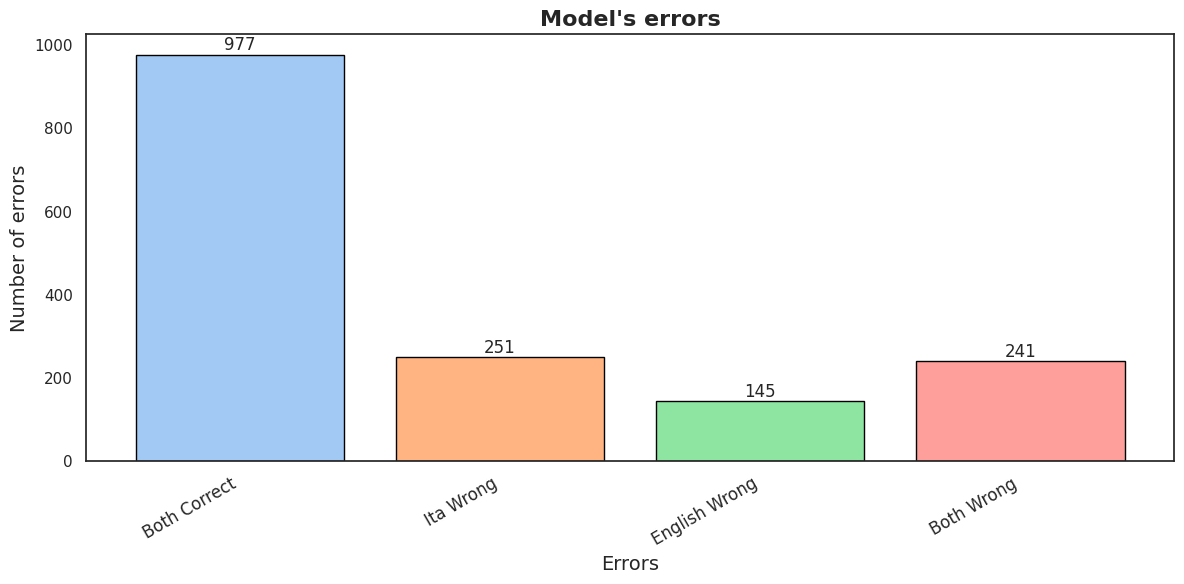

In [ ]:
dataset_names = ['Both Correct', 'Ita Wrong', 'English Wrong', 'Both Wrong']
dataset_lengths = [len(df_correct_predictions), len(df_different_predictions_eng), len(df_different_predictions_ita), len(df_both_incorrect_predictions)]

plt.figure(figsize=(12, 6))
sns.set(style="white")

colors = sns.color_palette("pastel")
bars = plt.bar(dataset_names, dataset_lengths, color=colors, edgecolor='black')

plt.xlabel('Errors', fontsize=14)
plt.ylabel('Number of errors', fontsize=14)
plt.title('Model\'s errors', fontsize=16, fontweight='bold')
plt.xticks(rotation=30, ha='right', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


#**Italian Bert**

In [ ]:
model_name = "dbmdz/bert-base-italian-xxl-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(concatenated_df_train_google['label'].unique()))

In [ ]:
training(concatenated_df_train_google)

In [ ]:
# Directory to save the model on Google Drive
save_directory = "/content/drive/My Drive/model_weight_hg"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Path to save the model weights
model_save_path = os.path.join(save_directory, "bert_model_weights.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

In [ ]:
#rende int tutte le stringhe. Effettuo questo check per qualsiasi dataset
concatenated_df_test_google['label'] = concatenated_df_test_google['label'].astype(int)
concatenated_df_test_original['label'] = concatenated_df_test_original['label'].astype(int)

dreaddit_test_google['label'] = dreaddit_test_google['label'].astype(int)
dreaddit_test_original['label'] = dreaddit_test_original['label'].astype(int)

sdcnl_test_google['label'] = sdcnl_test_google['label'].astype(int)
sdcnl_test_original['label'] = sdcnl_test_original['label'].astype(int)

dep_severity_test_google['label'] = dep_severity_test_google['label'].astype(int)
dep_severity_test_original['label'] = dep_severity_test_original['label'].astype(int)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_hg"
model_save_path = os.path.join(save_directory, "bert_model_weights.pth")

model.load_state_dict(torch.load(model_save_path))
bal_acc = testing(concatenated_df_test_google, concatenated_df_train_google)

model_save_path_csv = os.path.splitext(model_save_path)[0] + ".csv"

concatenated_df_test_google.to_csv(model_save_path_csv, index=False)


data = {'Model':os.path.splitext(os.path.basename(model_save_path))[0], 'bal_acc':bal_acc}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)


#**Roberta Ita**

In [ ]:
model_name = "osiria/roberta-base-italian"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(concatenated_df_train_google['label'].unique()))

In [ ]:
training(concatenated_df_train_google)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_hg"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)


model_save_path = os.path.join(save_directory, "Roberta_model_weights.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

In [ ]:
#rende int tutte le stringhe. Effettuo questo check per qualsiasi dataset
concatenated_df_test_google['label'] = concatenated_df_test_google['label'].astype(int)
concatenated_df_test_original['label'] = concatenated_df_test_original['label'].astype(int)

dreaddit_test_google['label'] = dreaddit_test_google['label'].astype(int)
dreaddit_test_original['label'] = dreaddit_test_original['label'].astype(int)

sdcnl_test_google['label'] = sdcnl_test_google['label'].astype(int)
sdcnl_test_original['label'] = sdcnl_test_original['label'].astype(int)

dep_severity_test_google['label'] = dep_severity_test_google['label'].astype(int)
dep_severity_test_original['label'] = dep_severity_test_original['label'].astype(int)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_hg"
model_save_path = os.path.join(save_directory, "Roberta_model_weights.pth")

model.load_state_dict(torch.load(model_save_path))
bal_acc = testing(concatenated_df_test_google, concatenated_df_train_google)


model_save_path_csv = os.path.splitext(model_save_path)[0] + ".csv"

concatenated_df_test_google.to_csv(model_save_path_csv, index=False)


data = {'Model':os.path.splitext(os.path.basename(model_save_path))[0], 'bal_acc':bal_acc}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)


#**Roberta**

In [ ]:
model_name = "FacebookAI/roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(concatenated_df_train_original['label'].unique()))

In [ ]:
training(concatenated_df_train_original)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_hg"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)


model_save_path = os.path.join(save_directory, "Roberta_eng_model_weights.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

In [ ]:
concatenated_df_test_google['label'] = concatenated_df_test_google['label'].astype(int)
concatenated_df_test_original['label'] = concatenated_df_test_original['label'].astype(int)

dreaddit_test_google['label'] = dreaddit_test_google['label'].astype(int)
dreaddit_test_original['label'] = dreaddit_test_original['label'].astype(int)

sdcnl_test_google['label'] = sdcnl_test_google['label'].astype(int)
sdcnl_test_original['label'] = sdcnl_test_original['label'].astype(int)

dep_severity_test_google['label'] = dep_severity_test_google['label'].astype(int)
dep_severity_test_original['label'] = dep_severity_test_original['label'].astype(int)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_hg"
model_save_path = os.path.join(save_directory, "Roberta_eng_model_weights.pth")

model.load_state_dict(torch.load(model_save_path))
bal_acc = testing(concatenated_df_test_original, concatenated_df_train_original)


model_save_path_csv = os.path.splitext(model_save_path)[0] + ".csv"

concatenated_df_test_original.to_csv(model_save_path_csv, index=False)


data = {'Model':os.path.splitext(os.path.basename(model_save_path))[0], 'bal_acc':bal_acc}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)


#**QWEN**

**Codice unito fornito solo per QWEN**

ValueError: Cannot handle batch sizes > 1 if no padding token is defined

In [ ]:
model_name = "Qwen/Qwen2-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(dep_severity_train_google['label'].unique()))

In [ ]:
training_qwen(dep_severity_train_google)

In [ ]:
concatenated_df_test_google['label'] = concatenated_df_test_google['label'].astype(int)
concatenated_df_test_original['label'] = concatenated_df_test_original['label'].astype(int)

dreaddit_test_google['label'] = dreaddit_test_google['label'].astype(int)
dreaddit_test_original['label'] = dreaddit_test_original['label'].astype(int)

sdcnl_test_google['label'] = sdcnl_test_google['label'].astype(int)
sdcnl_test_original['label'] = sdcnl_test_original['label'].astype(int)

dep_severity_test_google['label'] = dep_severity_test_google['label'].astype(int)
dep_severity_test_original['label'] = dep_severity_test_original['label'].astype(int)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_hg"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

model_save_path = os.path.join(save_directory, "qwen2_eng_model_weights.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

model.load_state_dict(torch.load(model_save_path))
bal_acc = testing_qwen(dep_severity_test_google, dep_severity_train_google)

model_save_path_csv = os.path.splitext(model_save_path)[0] + ".csv"
dep_severity_test_google.to_csv(model_save_path_csv, index=False)

data = {'Model': os.path.splitext(os.path.basename(model_save_path))[0], 'bal_acc': bal_acc}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)


#**CrossLanguage FlanT5**

In [ ]:
model_name ="google/flan-t5-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(dep_severity_train_google['label'].unique()))

In [ ]:
concatenated_df_test_google['label'] = concatenated_df_test_google['label'].astype(int)
concatenated_df_test_original['label'] = concatenated_df_test_original['label'].astype(int)

dreaddit_test_google['label'] = dreaddit_test_google['label'].astype(int)
dreaddit_test_original['label'] = dreaddit_test_original['label'].astype(int)

sdcnl_test_google['label'] = sdcnl_test_google['label'].astype(int)
sdcnl_test_original['label'] = sdcnl_test_original['label'].astype(int)

dep_severity_test_google['label'] = dep_severity_test_google['label'].astype(int)
dep_severity_test_original['label'] = dep_severity_test_original['label'].astype(int)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_task_2 (1)"
model_save_path = os.path.join(save_directory, "flant5_model_weights_helsinki.pth")

to_save_directory = "/content/drive/My Drive/model_weight_crosslinguage/Dep_severity_task_2"
model_to_save_path = os.path.join(to_save_directory, "flant5_helsinki_eng_model_weights.csv")

model.load_state_dict(torch.load(model_save_path))
bal_acc = testing(dep_severity_test_google, dep_severity_train_google)


model_save_path_csv = os.path.splitext(model_save_path)[0] + ".csv"


dep_severity_test_original.to_csv(model_to_save_path, index=False)


data = {'Model':os.path.splitext(os.path.basename(model_to_save_path))[0], 'bal_acc':bal_acc}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(to_save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)


#**Crosslanguage Bert**

In [ ]:
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(dep_severity_train_original['label'].unique()))

In [ ]:
training(dep_severity_train_original)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_crosslinguage/Dep_severity"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)


model_save_path = os.path.join(save_directory, "bert_eng_model_weights.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

In [ ]:
concatenated_df_test_google['label'] = concatenated_df_test_google['label'].astype(int)
concatenated_df_test_original['label'] = concatenated_df_test_original['label'].astype(int)

dreaddit_test_google['label'] = dreaddit_test_google['label'].astype(int)
dreaddit_test_original['label'] = dreaddit_test_original['label'].astype(int)

sdcnl_test_google['label'] = sdcnl_test_google['label'].astype(int)
sdcnl_test_original['label'] = sdcnl_test_original['label'].astype(int)

dep_severity_test_google['label'] = dep_severity_test_google['label'].astype(int)
dep_severity_test_original['label'] = dep_severity_test_original['label'].astype(int)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_crosslinguage/Dreaddit"
model_save_path = os.path.join(save_directory, "bert_eng_model_weights.pth")

to_save_directory = "/content/drive/My Drive/model_weight_crosslinguage/Dreaddit"
model_to_save_path = os.path.join(to_save_directory, "bert_eng_google_model_weights.csv")

model.load_state_dict(torch.load(model_save_path))
bal_acc = testing(dep_severity_test_google, dep_severity_train_google)


model_save_path_csv = os.path.splitext(model_save_path)[0] + ".csv"


dep_severity_test_google.to_csv(model_to_save_path, index=False)


data = {'Model':os.path.splitext(os.path.basename(model_to_save_path))[0], 'bal_acc':bal_acc}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(to_save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)


#**Cross Language Roberta**

In [ ]:
model_name="FacebookAI/xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(dep_severity_train_google['label'].unique()))

In [ ]:
training(dep_severity_train_google)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_crosslinguage/Dep_severity"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)


model_save_path = os.path.join(save_directory, "Roberta_model_weights.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

In [ ]:
concatenated_df_test_google['label'] = concatenated_df_test_google['label'].astype(int)
concatenated_df_test_original['label'] = concatenated_df_test_original['label'].astype(int)

dreaddit_test_google['label'] = dreaddit_test_google['label'].astype(int)
dreaddit_test_original['label'] = dreaddit_test_original['label'].astype(int)

sdcnl_test_google['label'] = sdcnl_test_google['label'].astype(int)
sdcnl_test_original['label'] = sdcnl_test_original['label'].astype(int)

dep_severity_test_google['label'] = dep_severity_test_google['label'].astype(int)
dep_severity_test_original['label'] = dep_severity_test_original['label'].astype(int)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_crosslinguage/Dep_severity"
model_save_path = os.path.join(save_directory, "Roberta_model_weights.pth")

to_save_directory = "/content/drive/My Drive/model_weight_crosslinguage/Dep_severity"
model_to_save_path = os.path.join(to_save_directory, "Roberta_google_eng_model_weights.csv")

model.load_state_dict(torch.load(model_save_path))

bal_acc = testing(dep_severity_test_original, dep_severity_train_original)


model_save_path_csv = os.path.splitext(model_save_path)[0] + ".csv"

dep_severity_test_original.to_csv(model_to_save_path, index=False)


data = {'Model':os.path.splitext(os.path.basename(model_to_save_path))[0], 'bal_acc':bal_acc}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(to_save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)


#**CrossLanguage QWEN0.5**

In [ ]:
model_name ="Qwen/Qwen2-0.5B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(dep_severity_train_helsinki['label'].unique()))

In [ ]:
concatenated_df_test_google['label'] = concatenated_df_test_google['label'].astype(int)
concatenated_df_test_original['label'] = concatenated_df_test_original['label'].astype(int)

dreaddit_test_google['label'] = dreaddit_test_google['label'].astype(int)
dreaddit_test_original['label'] = dreaddit_test_original['label'].astype(int)

sdcnl_test_google['label'] = sdcnl_test_google['label'].astype(int)
sdcnl_test_original['label'] = sdcnl_test_original['label'].astype(int)

dep_severity_test_google['label'] = dep_severity_test_google['label'].astype(int)
dep_severity_test_original['label'] = dep_severity_test_original['label'].astype(int)

In [ ]:
save_directory = "/content/drive/My Drive/model_weight_hg"
model_save_path = os.path.join(save_directory, "qwen2_eng_model_weights.pth")


to_save_directory = "/content/drive/MyDrive/model_weight_crosslinguage/Dep_severity"
model_to_save_path = os.path.join(to_save_directory, "qwen2_google_eng_model_weights.csv")

model.load_state_dict(torch.load(model_save_path))
bal_acc = testing_qwen(dep_severity_test_original, dep_severity_train_original)


model_save_path_csv = os.path.splitext(model_save_path)[0] + ".csv"


dep_severity_test_original.to_csv(model_to_save_path, index=False)


data = {'Model':os.path.splitext(os.path.basename(model_to_save_path))[0], 'bal_acc':bal_acc}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(to_save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)


#**Clean text LLM**

In [ ]:
def clean_text(text):
    text = text.replace('\n', ' ')
    text = ' '.join(text.split())
    return text

In [ ]:
dreaddit_test_original.loc[:, 'text'] = dreaddit_test_original['text'].apply(clean_text)
sdcnl_test_original.loc[:, 'selftext'] = sdcnl_test_original['selftext'].apply(clean_text)
dep_severity_test_original.loc[:, 'text'] = dep_severity_test_original['text'].apply(clean_text)
dreaddit_test_google.loc[:, 'text tradotto'] = dreaddit_test_google['text tradotto'].apply(clean_text)
sdcnl_test_google.loc[:, 'text tradotto'] = sdcnl_test_google['text tradotto'].apply(clean_text)
dep_severity_test_google.loc[:, 'text tradotto'] = dep_severity_test_google['text tradotto'].apply(clean_text)

#**FLAN T5 Zero-shot**

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration
from huggingface_hub import login
import os
from sklearn.metrics import balanced_accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "google/flan-t5-large"
dtype = torch.bfloat16


tokenizer = AutoTokenizer.from_pretrained(model_id)
model = T5ForConditionalGeneration.from_pretrained(model_id, torch_dtype=dtype).to(device)

def generate_prompt(text, strategy_prompt, question_prompt):
    return f"{text} {strategy_prompt} {question_prompt}"




strategy_prompts = {
    "Basic": "",
    "Context Enhancement": "Consider this post on social media to answer the question.",
    "Mental Health Enhancement": "As a psychologist, read the post on social media and answer the question.",
    "Context & Mental Health Enhancement": "This person wrote this paragraph on social media. As a psychologist, consider the mental well-being condition expressed in this post, read the post on social media, and answer the question."
}

#Select the qustion based on the dataset
question_prompts = {
    #"Dreaddit" :"Is the poster of this post stressed? Answer only with Yes or No."
    # "SDCNL" :"Is the poster likely to suicide? Answer only with Yes or No."
    # "DepSeverity" :"Is the poster of this post depressed? Answer only with Yes or No."
    "DepSeverity multiclass":"Which level is the poster depressed? Return a level from 0 to 3, where 0 is minimum."
}

results = []

# HERE TO CHANGE DF
for index, row in dep_severity_test_original.iterrows():
  # HERE TO CHANGE COLUMN
    text = row['text']

    for strategy_name, strategy_prompt in strategy_prompts.items():
        for question_name, question_prompt in question_prompts.items():
            prompt = generate_prompt(text, strategy_prompt, question_prompt)
            inputs = tokenizer(prompt, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model.generate(**inputs, max_length=500)

            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            print(generated_text)

            # Logica euristica binaria
            # if "si" in generated_text.lower() or "yes" in generated_text.lower():
            #     label = 1
            # elif "no" in generated_text.lower():
            #     label = 0
            # else:
            #     label ='not found'

            #Logica euristica multiclass

            if "1" in generated_text :
                label = 1
            elif "2" in generated_text:
                label = 2
            elif "3" in generated_text:
                label = 3
            elif "0" in generated_text:
                label = 0
            else:
                label = "not found"



            result_dict = {
                'text': text,
                'strategy': strategy_name,
                'question': question_name,
                'prompt': prompt,
                'generated_text': generated_text,
                'result': label,
            }
            results.append(result_dict)

results_df = pd.DataFrame(results)

# HERE TO CHANGE DF and text
merged_df = pd.merge(results_df, dep_severity_test_original, left_on="text", right_on="text", how="left")
merged_df = merged_df[merged_df['result'] != 'not found']

bal_acc_score = 0
type_of_prompt = 'Basic'

strategies = [
    'Basic',
    'Context Enhancement',
    'Mental Health Enhancement',
    'Context & Mental Health Enhancement'
]

for strategy in strategies:
    df = merged_df[merged_df['strategy'] == strategy]
    all_labels = df['label']
    all_predictions = df['result']
    all_labels = all_labels.astype(int)
    all_predictions = all_predictions.astype(int)
    #For multiclass prediction
    #bal_acc = balanced_accuracy_severity(all_labels, all_predictions)
    bal_acc = balanced_accuracy(all_labels, all_predictions)
    if bal_acc > bal_acc_score:
        bal_acc_score = bal_acc
        type_of_prompt = strategy

save_directory = "/content/drive/My Drive/csv_zero_shot/"
# HERE TO CHANGE Name
csv_save_path = os.path.join(save_directory, "dreaddit_test_original_flant5.csv")
merged_df.to_csv(csv_save_path, index=False)

data = {'Model': os.path.splitext(os.path.basename(csv_save_path))[0], 'bal_acc': bal_acc_score, 'Prompt': type_of_prompt}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc', 'Prompt'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)

print("Risultati salvati in:", csv_save_path)


#**Flan T5 italian Zero-shot**


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, T5ForConditionalGeneration
from huggingface_hub import login
import os
from sklearn.metrics import balanced_accuracy_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "google/flan-t5-large"
dtype = torch.bfloat16

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = T5ForConditionalGeneration.from_pretrained(model_id, torch_dtype=dtype).to(device)

def generate_prompt(text, strategy_prompt, question_prompt):
    return f"{text} {strategy_prompt} {question_prompt}"

strategy_prompts = {
    "Basic": "",
    "Context Enhancement": "Considera questo post presente sui social media per rispondere alla seguente domanda.",
    "Mental Health Enhancement": "Come se fossi uno psicologo, leggi il post scritto su un social media e rispondi alla domanda.",
    "Context & Mental Health Enhancement": "Questa persona ha scritto questo paragrafo su un social media. Come se fossi psicologo, considera la condizione di benessere mentale espressa in questo post, leggi il post scritto su un social media e rispondi alla domanda."
}

question_prompts = {
    "Dreaddit": "Lo scrittore di questo post risulta essere stressato? Rispondi con Sì o No."
    #"SDCNL" :"Lo scrittore di questo post vuole suicidarsi? Rispondi solo con Sì o No."
    #"DepSeverity": "Lo scrittore di questo post risulta essere depresso? Rispondi solo con Sì o No."
    #"DepSeverity multiclass":"A che livello lo scrittore di questo post risulta essere depresso? Rispondi con un livello da 0 a 3 per indicare il livello di depressione."
}

results = []
# HERE TO CHANGE DF
for index, row in dep_severity_test_google.iterrows():
    text = row['text tradotto']

    for strategy_name, strategy_prompt in strategy_prompts.items():
        for question_name, question_prompt in question_prompts.items():
            prompt = generate_prompt(text, strategy_prompt, question_prompt)
            inputs = tokenizer(prompt, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model.generate(**inputs, max_length=500)

            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            print(generated_text)

            # Logica euristica binaria
            # if "si" in generated_text.lower() or "yes" in generated_text.lower():
            #     label = 1
            # elif "no" in generated_text.lower():
            #     label = 0
            # else:
            #     label ='not found'

            #Logica euristica multiclass

            if "1" in generated_text :
                label = 1
            elif "2" in generated_text:
                label = 2
            elif "3" in generated_text:
                label = 3
            elif "0" in generated_text:
                label = 0
            else:
                label = "not found"

            result_dict = {
                'text': text,
                'strategy': strategy_name,
                'question': question_name,
                'prompt': prompt,
                'generated_text': generated_text,
                'result': label,
            }
            results.append(result_dict)

results_df = pd.DataFrame(results)
# HERE TO CHANGE DF
merged_df = pd.merge(results_df, dep_severity_test_google, left_on="text", right_on="text tradotto", how="left")
merged_df = merged_df[merged_df['result'] != 'not found']

bal_acc_score = 0
type_of_prompt = 'Basic'

strategies = [
    'Basic',
    'Context Enhancement',
    'Mental Health Enhancement',
    'Context & Mental Health Enhancement'
]

for strategy in strategies:
    df = merged_df[merged_df['strategy'] == strategy]
    all_labels = df['label']
    all_predictions = df['result']
    all_labels = all_labels.astype(int)
    all_predictions = all_predictions.astype(int)
    #bal_acc = balanced_accuracy_severity(all_labels, all_predictions)
    bal_acc = balanced_accuracy(all_labels, all_predictions)
    if bal_acc > bal_acc_score:
        bal_acc_score = bal_acc
        type_of_prompt = strategy

save_directory = "/content/drive/My Drive/csv_zero_shot/"
csv_save_path = os.path.join(save_directory, "dreaddit_test_google_flan.csv")
merged_df.to_csv(csv_save_path, index=False)

data = {'Model': os.path.splitext(os.path.basename(csv_save_path))[0], 'bal_acc': bal_acc_score, 'Prompt': type_of_prompt}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc', 'Prompt'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)

print("Risultati salvati in:", csv_save_path)


#**Bert zero shot**

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, BertForSequenceClassification
from huggingface_hub import login
import os
from sklearn.metrics import balanced_accuracy_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_id = "bert-base-uncased"
dtype = torch.bfloat16

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = BertForSequenceClassification.from_pretrained(model_id, num_labels=2).to(device)

def generate_prompt(text, strategy_prompt, question_prompt):
    return f"{text} {strategy_prompt} {question_prompt}"


strategy_prompts = {
    "Basic": "",
    "Context Enhancement": "Consider this post on social media to answer the question.",
    "Mental Health Enhancement": "As a psychologist, read the post on social media and answer the question.",
    "Context & Mental Health Enhancement": "This person wrote this paragraph on social media. As a psychologist, consider the mental well-being condition expressed in this post, read the post on social media, and answer the question."
}

question_prompts = {
    "Dreaddit": "is the poster of this post stressed? Answer only with 1 or 0."
    #"SDCNL" :"Is the poster likely to suicide? Answer only with 1 or 0."
    #"DepSeverity" :"is the poster of this post depressed? Answer only with 1 or 0."
    #"DepSeverity multiclass":"Which level is the poster depressed? Return a level from 0 to 3, where 0 is minimum."
}

results = []
# HERE TO CHANGE DF
for index, row in dreaddit_test_original.iterrows():
    text = row['text']

    for strategy_name, strategy_prompt in strategy_prompts.items():
        for question_name, question_prompt in question_prompts.items():
            prompt = generate_prompt(text, strategy_prompt, question_prompt)
            inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                label = torch.argmax(logits, dim=1).item()
                print(label)

            #label = 1 if predicted_class == 1 else 0

            result_dict = {
                'text': text,
                'strategy': strategy_name,
                'question': question_name,
                'prompt': prompt,
                #'generated_text': "Yes" if label == 1 else "No",
                'result': label,
            }
            results.append(result_dict)

results_df = pd.DataFrame(results)

# HERE TO CHANGE DF
merged_df = pd.merge(results_df, dreaddit_test_original, left_on="text", right_on="text", how="left")
merged_df = merged_df[merged_df['result'] != 'not found']

bal_acc_score = 0
type_of_prompt = 'Basic'

strategies = [
    'Basic',
    'Context Enhancement',
    'Mental Health Enhancement',
    'Context & Mental Health Enhancement'
]

for strategy in strategies:
    df = merged_df[merged_df['strategy'] == strategy]
    all_labels = df['label']
    all_predictions = df['result']
    all_labels = all_labels.astype(int)
    all_predictions = all_predictions.astype(int)
    #bal_acc = balanced_accuracy_severity(all_labels, all_predictions)
    bal_acc = balanced_accuracy(all_labels, all_predictions)
    if bal_acc > bal_acc_score:
        bal_acc_score = bal_acc
        type_of_prompt = strategy

save_directory = "/content/drive/My Drive/csv_zero_shot/"
csv_save_path = os.path.join(save_directory, "dep_severity_test_original_bert.csv")
merged_df.to_csv(csv_save_path, index=False)

data = {'Model': os.path.splitext(os.path.basename(csv_save_path))[0], 'bal_acc': bal_acc_score, 'Prompt': type_of_prompt}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc', 'Prompt'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)

print("Risultati salvati in:", csv_save_path)


#**Bert Ita zero-shot**

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, BertForSequenceClassification
from huggingface_hub import login
import os
from sklearn.metrics import balanced_accuracy_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "dbmdz/bert-base-italian-xxl-cased"
dtype = torch.bfloat16

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = BertForSequenceClassification.from_pretrained(model_id, num_labels=2).to(device)

def generate_prompt(text, strategy_prompt, question_prompt):
    return f"{text} {strategy_prompt} {question_prompt}"


strategy_prompts = {
    "Basic": "",
    "Context Enhancement": "Considera questo post presente sui social media per rispondere alla seguente domanda.",
    "Mental Health Enhancement": "Come se fossi uno psicologo, leggi il post scritto su un social media e rispondi alla domanda.",
    "Context & Mental Health Enhancement": "Questa persona ha scritto questo paragrafo su un social media. Come se fossi psicologo, considera la condizione di benessere mentale espressa in questo post, leggi il post scritto su un social media e rispondi alla domanda."
}


question_prompts = {
    #"Dreaddit": "Lo scrittore di questo post risulta essere stressato? Rispondi solo con 1 o 0."
    #"SDCNL" :"Lo scrittore di questo post vuole suicidarsi? Rispondi solo con 1 o 0."
    #"DepSeverity": "Lo scrittore di questo post risulta essere depresso? Rispondi solo con 1 o 0."
    "DepSeverity Multiclass":"A che livello lo scrittore di questo post risulta essere depresso? Rispondi con un livello da 0 a 3 per indicare il livello di depressione."
}

results = []
# HERE TO CHANGE DF
for index, row in dep_severity_test_google.iterrows():
    text = row['text tradotto']

    for strategy_name, strategy_prompt in strategy_prompts.items():
        for question_name, question_prompt in question_prompts.items():
            prompt = generate_prompt(text, strategy_prompt, question_prompt)
            inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                label = torch.argmax(logits, dim=1).item()
                print(label)

            #label = 1 if predicted_class == 1 else 0

            result_dict = {
                'text': text,
                'strategy': strategy_name,
                'question': question_name,
                'prompt': prompt,
                'generated_text': "Yes" if label == 1 else "No",
                'result': label,
            }
            results.append(result_dict)

results_df = pd.DataFrame(results)
# HERE TO CHANGE DF
merged_df = pd.merge(results_df, dep_severity_test_google, left_on="text", right_on="text tradotto", how="left")
merged_df = merged_df[merged_df['result'] != 'not found']

bal_acc_score = 0
type_of_prompt = 'Basic'

strategies = [
    'Basic',
    'Context Enhancement',
    'Mental Health Enhancement',
    'Context & Mental Health Enhancement'
]

for strategy in strategies:
    df = merged_df[merged_df['strategy'] == strategy]
    all_labels = df['label']
    all_predictions = df['result']
    all_labels = all_labels.astype(int)
    all_predictions = all_predictions.astype(int)
    #bal_acc = balanced_accuracy_severity(all_labels, all_predictions)
    bal_acc = balanced_accuracy(all_labels, all_predictions)
    if bal_acc > bal_acc_score:
        bal_acc_score = bal_acc
        type_of_prompt = strategy

save_directory = "/content/drive/My Drive/csv_zero_shot/"
csv_save_path = os.path.join(save_directory, "dep_severity_test_google_bert.csv")
merged_df.to_csv(csv_save_path, index=False)

data = {'Model': os.path.splitext(os.path.basename(csv_save_path))[0], 'bal_acc': bal_acc_score, 'Prompt': type_of_prompt}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc', 'Prompt'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)

print("Risultati salvati in:", csv_save_path)


#**Qwen2-0.5B-Instruct zero-shot**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "Qwen/Qwen2-0.5B-Instruct"
dtype = torch.bfloat16
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=dtype).to(device)



question_prompts = {
    "Dreaddit" :"is the poster of this post stressed? Answer only with Yes or No."
    #"SDCNL" :"Is the poster likely to suicide? Answer only with Yes or No. "
    #"DepSeverity" :"is the poster of this post depressed? Answer with Yes or No."
    #"DepSeverity Multiclass":"Which level is the poster depressed? Answer with a level from 0 to 3, where 0 is minimum."
    }


strategy_prompts = {
    "Basic": "",
    "Context Enhancement": "Consider this post on social media to answer the question.",
    "Mental Health Enhancement": "As a psychologist, read the post on social media and answer the question.",
    "Context & Mental Health Enhancement": "This person wrote this paragraph on social media. As a psychologist, consider the mental well-being condition expressed in this post, read the post on social media, and answer the question."
}

results=[]
i=0
# HERE TO CHANGE DF
for index, row in dreaddit_test_original.iterrows():
    text = row['text']

    for strategy_name, strategy_prompt in strategy_prompts.items():
        for question_name, question_prompt in question_prompts.items():
            messages = [
                        {"role": "system", "content": f"{text} {strategy_prompt}"},
                        {"role": "user", "content": question_prompt}
                      ]
            text_tokenized = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)
            model_inputs = tokenizer([text_tokenized], return_tensors="pt").to(device)
            i+=1

            with torch.no_grad():
                outputs = model.generate(model_inputs.input_ids,max_new_tokens=512)
                generated_text = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, outputs)]
                response = tokenizer.batch_decode(generated_text, skip_special_tokens=True)[0]
                print('***********************************')
                print(i)
                print(response)

            #Binary
            first_word = response.split()[0].lower()
            if "yes" in first_word:
                label = 1
            elif "no" in first_word:
                label = 0
            else:
                label = "not found"


            #Multiclass
            # if "1" in response:
            #     label = 1
            # elif "2" in response:
            #     label = 2
            # elif "3" in response:
            #     label = 3
            # elif "0" in response:
            #     label = 0
            # else:
            #     label = "not found"


            result_dict = {
                'text': text,
                'strategy': strategy_name,
                'question': question_name,
                'prompt': question_prompt,
                'generated_text': response,
                'result': label,
            }
            results.append(result_dict)

results_df = pd.DataFrame(results)
# HERE TO CHANGE DF
merged_df = pd.merge(results_df, dreaddit_test_original, left_on="text", right_on="text", how="left")

not_found = merged_df[merged_df['result'] == 'not found']
merged_df = merged_df[merged_df['result'] != 'not found']

bal_acc_score = 0
type_of_prompt = 'Basic'

strategies = [
    'Basic',
    'Context Enhancement',
    'Mental Health Enhancement',
    'Context & Mental Health Enhancement'
]

for strategy in strategies:
    df = merged_df[merged_df['strategy'] == strategy]
    all_labels = df['label']
    all_predictions = df['result']
    all_labels = all_labels.astype(int)
    all_predictions = all_predictions.astype(int)
    #bal_acc = balanced_accuracy_severity(all_labels, all_predictions)
    bal_acc = balanced_accuracy(all_labels, all_predictions)
    if bal_acc > bal_acc_score:
        bal_acc_score = bal_acc
        type_of_prompt = strategy

save_directory = "/content/drive/My Drive/csv_zero_shot/"
csv_save_path = os.path.join(save_directory, "dep_severity_test_original_qwen05.csv")
merged_df.to_csv(csv_save_path, index=False)

data = {'Model': os.path.splitext(os.path.basename(csv_save_path))[0], 'bal_acc': bal_acc_score, 'Prompt': type_of_prompt}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc', 'Prompt'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)

print("Risultati salvati in:", csv_save_path)


#**Qwen2-0.5B-Instruct Italian zero-shot**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "Qwen/Qwen2-0.5B-Instruct"
dtype = torch.bfloat16
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=dtype).to(device)



strategy_prompts = {
    "Basic": "",
    "Context Enhancement": "Considera questo post presente sui social media per rispondere alla seguente domanda.",
    "Mental Health Enhancement": "Come se fossi uno psicologo, leggi il post scritto su un social media e rispondi alla domanda.",
    "Context & Mental Health Enhancement": "Questa persona ha scritto questo paragrafo su un social media. Come se fossi psicologo, considera la condizione di benessere mentale espressa in questo post, leggi il post scritto su un social media e rispondi alla domanda."
}

question_prompts = {
    "Dreaddit": "Lo scrittore di questo post risulta essere stressato? Rispondi solo con Sì o No."
    #"SDCNL" :"Lo scrittore di questo post vuole suicidarsi? Rispondi solo con Sì o No."
    #"DepSeverity": "Lo scrittore di questo post risulta essere depresso? Rispondi solo con Sì o No."
    #"DepSeverity Multiclass":"A che livello lo scrittore di questo post risulta essere depresso? Rispondi solo con da 0,1,2 o 3 dove 0 è il minimo."
}
results=[]
i=0
# HERE TO CHANGE DF
for index, row in dreaddit_test_google.iterrows():
    text = row['text tradotto']

    for strategy_name, strategy_prompt in strategy_prompts.items():
        for question_name, question_prompt in question_prompts.items():
            messages = [
                        {"role": "system", "content": f"{text} {strategy_prompt}"},
                        {"role": "user", "content": question_prompt}
                      ]
            text_tokenized = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)
            model_inputs = tokenizer([text_tokenized], return_tensors="pt").to(device)
            i+=1

            with torch.no_grad():
                outputs = model.generate(model_inputs.input_ids,max_new_tokens=512)
                generated_text = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, outputs)]
                response = tokenizer.batch_decode(generated_text, skip_special_tokens=True)[0]
                print('***********************************')
                print(i)
                print(response)

            #binary
            first_word = response.split()[0].lower()
            if "yes" in first_word or "sì" in first_word:
                label = 1
            elif "no" in first_word:
                label = 0
            else:
                label = "not found"

            #Multiclass
            # if "1" in response:
            #     label = 1
            # elif "2" in response:
            #     label = 2
            # elif "3" in response:
            #     label = 3
            # elif "0" in response:
            #     label = 0
            # else:
            #     label = "not found"

            print(label)

            result_dict = {
                'text': text,
                'strategy': strategy_name,
                'question': question_name,
                'prompt': question_prompt,
                'generated_text': response,
                'result': label,
            }
            results.append(result_dict)

results_df = pd.DataFrame(results)
# HERE TO CHANGE DF
merged_df = pd.merge(results_df, dreaddit_test_google, left_on="text", right_on="text tradotto", how="left")

not_found = merged_df[merged_df['result'] == 'not found']
merged_df = merged_df[merged_df['result'] != 'not found']

bal_acc_score = 0
type_of_prompt = 'Basic'

strategies = [
    'Basic',
    'Context Enhancement',
    'Mental Health Enhancement',
    'Context & Mental Health Enhancement'
]

for strategy in strategies:
    df = merged_df[merged_df['strategy'] == strategy]
    all_labels = df['label']
    all_predictions = df['result']
    all_labels = all_labels.astype(int)
    all_predictions = all_predictions.astype(int)
    # bal_acc = balanced_accuracy_severity(all_labels, all_predictions)
    bal_acc = balanced_accuracy(all_labels, all_predictions)
    if bal_acc > bal_acc_score:
        bal_acc_score = bal_acc
        type_of_prompt = strategy

save_directory = "/content/drive/My Drive/csv_zero_shot/"
csv_save_path = os.path.join(save_directory, "dep_severity_test_google_qwen05.csv")
merged_df.to_csv(csv_save_path, index=False)

data = {'Model': os.path.splitext(os.path.basename(csv_save_path))[0], 'bal_acc': bal_acc_score, 'Prompt': type_of_prompt}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc', 'Prompt'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)

print("Risultati salvati in:", csv_save_path)


#**Qwen2-1.5B-Instruct zero-shot**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "Qwen/Qwen2-1.5B-Instruct"
dtype = torch.bfloat16
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=dtype).to(device)



strategy_prompts = {
    "Basic": "",
    "Context Enhancement": "Consider this post on social media to answer the question.",
    "Mental Health Enhancement": "As a psychologist, read the post on social media and answer the question.",
    "Context & Mental Health Enhancement": "This person wrote this paragraph on social media. As a psychologist, consider the mental well-being condition expressed in this post, read the post on social media, and answer the question."
}

question_prompts = {

    "Dreaddit" :"is the poster of this post stressed? Answer with Yes or No."
    #"SDCNL" :"Is the poster likely to suicide? Answer with Yes or No."
    #"DepSeverity" :"is the poster of this post depressed? Answer with Yes or No."
    #"DepSeverity Multiclass":"Which level is the poster depressed? Answer with level from 0 to 3, where 0 is minimum."
}

results=[]
i=0
# HERE TO CHANGE DF
for index, row in dreaddit_test_original.iterrows():
    text = row['text']

    for strategy_name, strategy_prompt in strategy_prompts.items():
        for question_name, question_prompt in question_prompts.items():
            messages = [
                        {"role": "system", "content": f"{strategy_prompt} {text}"},
                        {"role": "user", "content": question_prompt}
                      ]
            text_tokenized = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)
            model_inputs = tokenizer([text_tokenized], return_tensors="pt").to(device)
            i+=1

            with torch.no_grad():
                outputs = model.generate(model_inputs.input_ids,max_new_tokens=512)
                generated_text = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, outputs)]
                response = tokenizer.batch_decode(generated_text, skip_special_tokens=True)[0]
                print('***********************************')
                print(i)
                print(response)

            #binary
            first_word = response.split()[0].lower()
            if "yes" in first_word:
                label = 1
            elif "no" in first_word:
                label = 0
            else:
                label = "not found"

                        #Multiclass
            # if "1" in response:
            #     label = 1
            # elif "2" in response:
            #     label = 2
            # elif "3" in response:
            #     label = 3
            # elif "0" in response:
            #     label = 0
            # else:
            #     label = "not found"

            print(label)

            result_dict = {
                'text': text,
                'strategy': strategy_name,
                'question': question_name,
                'prompt': question_prompt,
                'generated_text': response,
                'result': label,
            }
            results.append(result_dict)

results_df = pd.DataFrame(results)
# HERE TO CHANGE DF
merged_df = pd.merge(results_df, dreaddit_test_original, left_on="text", right_on="text", how="left")

not_found = merged_df[merged_df['result'] == 'not found']
merged_df = merged_df[merged_df['result'] != 'not found']

bal_acc_score = 0
type_of_prompt = 'Basic'

strategies = [
    'Basic',
    'Context Enhancement',
    'Mental Health Enhancement',
    'Context & Mental Health Enhancement'
]

for strategy in strategies:
    df = merged_df[merged_df['strategy'] == strategy]
    all_labels = df['label']
    all_predictions = df['result']
    all_labels = all_labels.astype(int)
    all_predictions = all_predictions.astype(int)
    #bal_acc = balanced_accuracy_severity(all_labels, all_predictions)
    bal_acc = balanced_accuracy(all_labels, all_predictions)
    if bal_acc > bal_acc_score:
        bal_acc_score = bal_acc
        type_of_prompt = strategy

save_directory = "/content/drive/My Drive/csv_zero_shot/"
csv_save_path = os.path.join(save_directory, "dep_severity_test_original_qwen15.csv")
merged_df.to_csv(csv_save_path, index=False)

data = {'Model': os.path.splitext(os.path.basename(csv_save_path))[0], 'bal_acc': bal_acc_score, 'Prompt': type_of_prompt}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc', 'Prompt'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)

print("Risultati salvati in:", csv_save_path)


#**Qwen2-1.5B-Instruct italian zero-shot**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "Qwen/Qwen2-1.5B-Instruct"
dtype = torch.bfloat16
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=dtype).to(device)



strategy_prompts = {
    "Basic": "",
    "Context Enhancement": "Considera questo post presente sui social media per rispondere alla seguente domanda.",
    "Mental Health Enhancement": "Come se fossi uno psicologo, leggi il post scritto su un social media e rispondi alla domanda.",
    "Context & Mental Health Enhancement": "Questa persona ha scritto questo paragrafo su un social media. Come se fossi psicologo, considera la condizione di benessere mentale espressa in questo post, leggi il post scritto su un social media e rispondi alla domanda."
}

question_prompts = {
    "Dreaddit": "Lo scrittore di questo post risulta essere stressato? Rispondi solo con Sì o No."
    #"SDCNL" :"Lo scrittore di questo post vuole suicidarsi? Rispondi solo con Sì o No."
    #"DepSeverity": "Lo scrittore di questo post risulta essere depresso? Rispondi solo con Sì o No."
    #"DepSeverity Multiclass":"A che livello lo scrittore di questo post risulta essere depresso? Rispondi solo con un livello compreso tra 0, 1, 2, 3."
}
results=[]
i=0
# HERE TO CHANGE DF
for index, row in dreaddit_test_google.iterrows():
    text = row['text tradotto']

    for strategy_name, strategy_prompt in strategy_prompts.items():
        for question_name, question_prompt in question_prompts.items():
            messages = [
                        {"role": "system", "content": f"{text} {strategy_prompt}"},
                        {"role": "user", "content": question_prompt}
                      ]
            text_tokenized = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)
            model_inputs = tokenizer([text_tokenized], return_tensors="pt").to(device)
            i+=1

            with torch.no_grad():
                outputs = model.generate(model_inputs.input_ids,max_new_tokens=512)
                generated_text = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, outputs)]
                response = tokenizer.batch_decode(generated_text, skip_special_tokens=True)[0]
                print('***********************************')
                print(i)
                print(response)

            # Binary
            first_word = response.split()[0].lower()
            if "yes" in first_word or "sì" in first_word:
                label = 1
            elif "no" in first_word:
                label = 0
            else:
                label = "not found"

            # #Multiclass
            # if "1" in response:
            #     label = 1
            # elif "2" in response:
            #     label = 2
            # elif "3" in response:
            #     label = 3
            # elif "0" in response:
            #     label = 0
            # else:
            #     label = "not found"

            print(label)

            result_dict = {
                'text': text,
                'strategy': strategy_name,
                'question': question_name,
                'prompt': question_prompt,
                'generated_text': response,
                'result': label,
            }
            results.append(result_dict)

results_df = pd.DataFrame(results)
# HERE TO CHANGE DF
merged_df = pd.merge(results_df, dreaddit_test_google, left_on="text", right_on="text tradotto", how="left")

not_found = merged_df[merged_df['result'] == 'not found']
merged_df = merged_df[merged_df['result'] != 'not found']

bal_acc_score = 0
type_of_prompt = 'Basic'

strategies = [
    'Basic',
    'Context Enhancement',
    'Mental Health Enhancement',
    'Context & Mental Health Enhancement'
]

for strategy in strategies:
    df = merged_df[merged_df['strategy'] == strategy]
    all_labels = df['label']
    all_predictions = df['result']
    all_labels = all_labels.astype(int)
    all_predictions = all_predictions.astype(int)
    #bal_acc = balanced_accuracy_severity(all_labels, all_predictions)
    bal_acc = balanced_accuracy(all_labels, all_predictions)
    if bal_acc > bal_acc_score:
        bal_acc_score = bal_acc
        type_of_prompt = strategy

save_directory = "/content/drive/My Drive/csv_zero_shot/"
csv_save_path = os.path.join(save_directory, "dep_severity_test_google_qwen15.csv")
merged_df.to_csv(csv_save_path, index=False)

data = {'Model': os.path.splitext(os.path.basename(csv_save_path))[0], 'bal_acc': bal_acc_score, 'Prompt': type_of_prompt}
new_data_df = pd.DataFrame([data])

bal_acc_csv_path = os.path.join(save_directory, "prediction.csv")
if os.path.exists(bal_acc_csv_path):
    df_bal_acc = pd.read_csv(bal_acc_csv_path)
else:
    df_bal_acc = pd.DataFrame(columns=['Model', 'bal_acc', 'Prompt'])
df_bal_acc = pd.concat([df_bal_acc, new_data_df], ignore_index=True)
df_bal_acc.to_csv(bal_acc_csv_path, index=False)

print("Risultati salvati in:", csv_save_path)
